## Cloning quasars

Let's look at the redshift distributions of the quasars in the Sloan Digital Sky Survey.

The Sloan Digital Sky Survey or SDSS is a major multi-spectral imaging and spectroscopic redshift survey using a dedicated 2.5-m wide-angle optical telescope at Apache Point Observatory in New Mexico, United States. Operations started in 1998.

In phase 1, SDSS has released photometry data 357 million (!!!) unique sources and 1.6 million spectra. In phase 2, SDSS observed the same patch of the sky many times ("time domain astronomy", and now we're going to have LSST!)

- Upsample this distribution in two ways, using both rejection sampling and inverse transform.
- Check, at least visually, that the two cloned distribitions are indeed similar to the observed one (for a quantitative check, come back to this point in a few lectures)

(Hint: `scipy.stats` is your best friend)

- Think about the cosmology of quasars. How do you think they are distributed? Overplot the theorethical distribution to the measured SDSS data. Does that agree with your expectation? 

(Hint: It shouldn't. But why?) 

(Hint: `astropy.cosmology` is another close friend). The best-fit cosmological model from the Plack data is:

In [11]:
import numpy as np
from matplotlib import pyplot as plt
from astroML.datasets import fetch_dr7_quasar
from scipy.interpolate import interp1d
from scipy.stats import rv_histogram, ks_2samp
from scipy.integrate import quad
from astropy.cosmology import Planck18

In [12]:
data = fetch_dr7_quasar()
z = data["redshift"][:10000]
N = len(z) 

## Dataset histogram and hypothesized redshift distribution

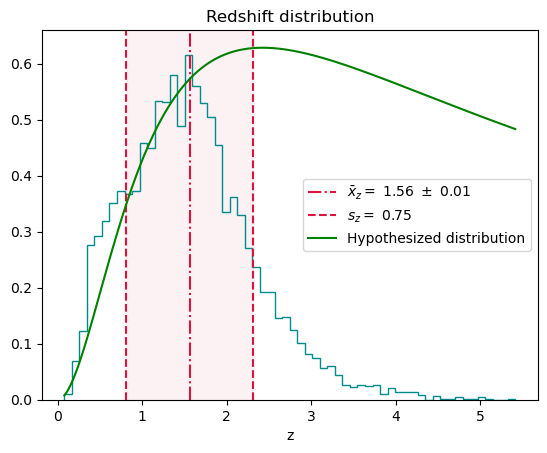

In [14]:
#Data histogram

mu_z = np.mean(z)
sigma_z = np.std(z)
sigma_mu = sigma_z / np.sqrt(N)

fig = plt.figure()
ax = fig.add_subplot()
hist = plt.hist(z, density=True, bins="fd", color="darkcyan", histtype="step")
plt.vlines(mu_z, 0, 1, transform=ax.get_xaxis_transform(), linestyles="-.", color="crimson", label="$\\bar{x}_z = $" + f"{mu_z: .2f}" + "$\ \pm$" + f"{sigma_mu: .2f}")
plt.vlines(mu_z - sigma_z, 0, 1, transform=ax.get_xaxis_transform(), linestyles="--", color="crimson", label="$s_z = $" + f"{sigma_z: .2f}")
plt.vlines(mu_z + sigma_z, 0, 1, transform=ax.get_xaxis_transform(), linestyles="--", color="crimson")
plt.fill_between([mu_z - sigma_z, mu_z + sigma_z], 1, color="crimson", alpha=0.06, transform=ax.get_xaxis_transform())
plt.title("Redshift distribution")
plt.xlabel("z")

#Hypothesized distribution of quasars (uniform in comoving volume)

def qso_pdf(z):
    return 4 * np.pi * Planck18.differential_comoving_volume(z).value

norm = quad(qso_pdf, 0, max(z))[0]

ax.plot(np.sort(z), 2.7 * qso_pdf(np.sort(z)) / norm, c="green", label="Hypothesized distribution")

plt.legend()

## Rejection sampling

In [16]:
#Distribution of the histogram

hist_distr = rv_histogram((hist[0], hist[1]))

n_couples = 5 * N    #Number of couples to generate

#Generate samples

unif_x = np.random.uniform(min(z), max(z), n_couples)
hist_pdf = hist_distr.pdf(unif_x)
unif_y = np.random.uniform(0, max(hist_pdf), n_couples)

sample = unif_x[np.where(unif_y < hist_pdf)]

## Inverse transform sampling

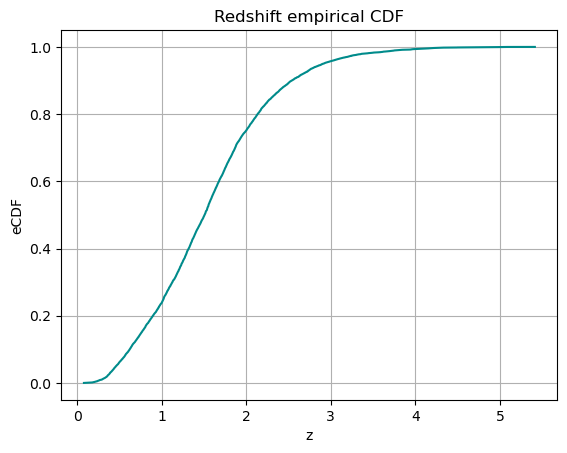

In [18]:
#Inverse transform sampling

#Empirical CDF

z = np.sort(z)
e_cdf = [len(np.where(z < i)[0]) / N for i in z]

fig_cdf = plt.figure()
ax_cdf = fig_cdf.add_subplot(1, 1, 1)
plt.plot(z, e_cdf, color="darkcyan")
plt.title("Redshift empirical CDF")
plt.xlabel("z")
plt.ylabel("eCDF")
plt.grid()

#Interpolate inverse eCDF and sample the redshift PDF

i_cdf = interp1d(e_cdf, z)
unif_cdf = np.random.uniform(0, max(e_cdf), N)
z_pdf = i_cdf(unif_cdf)

Rejection sampling KS test:
KstestResult(statistic=0.011724352948964123, pvalue=0.37692511461082234, statistic_location=1.8877999782562256, statistic_sign=1)

Inverse transform sampling KS test:
KstestResult(statistic=0.0119, pvalue=0.4784083389368079, statistic_location=1.138200044631958, statistic_sign=1)


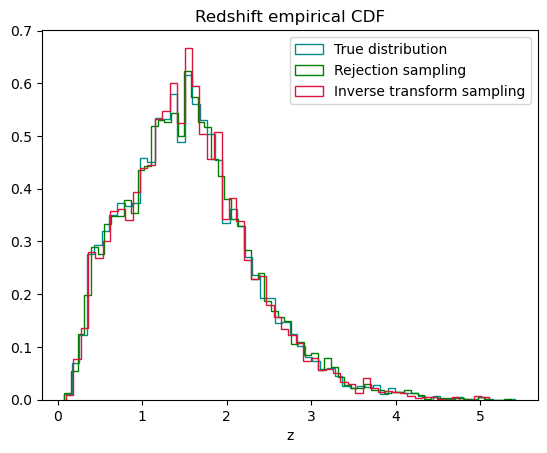

In [19]:
#Plot the distributions

plt.figure()
plt.hist(z, density=True, bins="fd", color="darkcyan", histtype="step", label="True distribution")
plt.hist(sample, density=True, bins="fd", color="green", histtype="step", label="Rejection sampling")
plt.hist(z_pdf, density=True, bins="fd", color="crimson", histtype="step", label="Inverse transform sampling")
plt.title("Redshift empirical CDF")
plt.xlabel("z")
plt.legend()

#Compare the distributions to the original one with a KS test

print("Rejection sampling KS test:\n" + str(ks_2samp(z, sample)) + "\n")
print("Inverse transform sampling KS test:\n" + str(ks_2samp(z, z_pdf)))

The cloned distributions match well to the original one, since the p value is high ($p > 5\%$)